In [1]:
import os
import sys
#set custom path
sys.path.insert(0, os.path.abspath(r'\users\fynn\documents\anaconda\envs\tf_keras_gpu_test\lib\site-packages'))

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
#gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333) 
#sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

1 Physical GPUs, 1 Logical GPUs


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from copy import deepcopy as dc


from PIL import Image
import requests
from io import BytesIO

%run data_functions.py

## Load Data

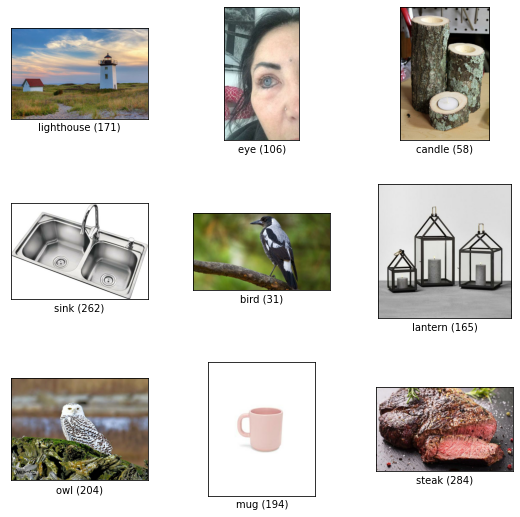

In [4]:
# Construct a tf.data.Dataset
domain_ds, domain_info = tfds.load('domainnet/real', with_info = True, split = 'train', as_supervised=True)
paintings_ds, paintings_info = tfds.load('domainnet/painting', with_info = True, split = 'train', as_supervised = True)

fig = tfds.show_examples(domain_ds, domain_info)

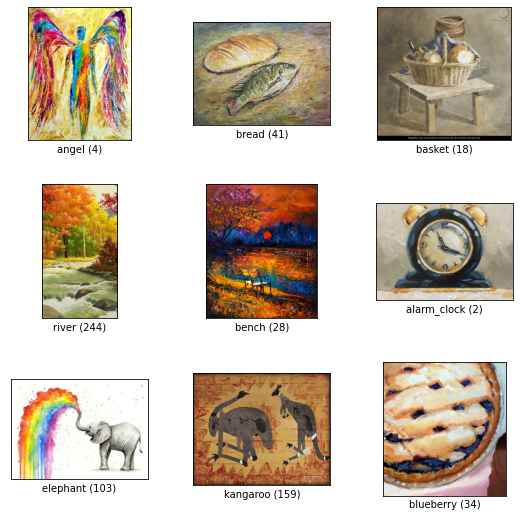

In [5]:
fig = tfds.show_examples(paintings_ds, paintings_info)

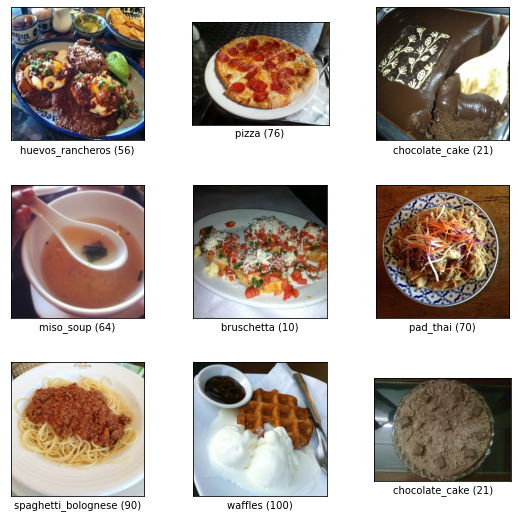

In [6]:
# Construct a tf.data.Dataset
food_ds, food_info = tfds.load('food101',  with_info = True, split = 'train', as_supervised=True)
fig = tfds.show_examples(food_ds, food_info)

1123


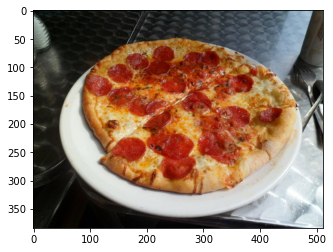

In [7]:
food_images, food_labels = select_photos(food_ds)

print(len(food_images))
plt.imshow(food_images[0])

1579


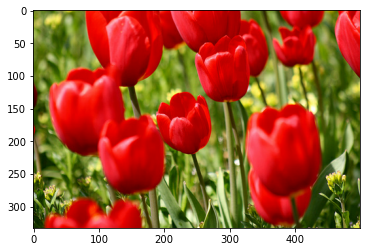

In [8]:
flower_images, flower_labels = select_photos(flower_ds, ratio_tol = 0.1)

print(len(flower_images))
plt.imshow(flower_images[0])

15850


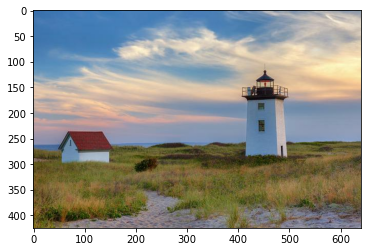

In [9]:
domain_images, domain_labels = select_photos(domain_ds, ratio_tol = 0.25, filter_range = 40000)

print(len(domain_images))
plt.imshow(domain_images[0])

1887


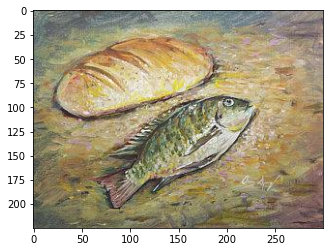

In [10]:
painting_images, painting_labels = select_photos(paintings_ds, ratio_tol = 0.25, filter_range = 5000)

print(len(painting_images))
plt.imshow(painting_images[0])

## DomainNet Classes

In [11]:
domain_cat_dict = {'Furniture': ['bathtub', 'bed', 'bench', 'ceiling fan', 'chair', 'chandelier', 'couch', 'door', 'dresser', 'fence', 'fireplace','floor lamp', 'hot tub', 'ladder', 'lantern', 'mailbox', 
                                 'picture frame', 'pillow', 'postcard','see saw','sink', 'sleeping bag', 'stairs', 'streetlight', 'suitcase', 'swing set', 'table', 'toilet', 'toothbrush', 
                                 'toothpaste', 'umbrella', 'vase'],
                   'Mammal': ['bat', 'cat', 'dolphin', 'hedgehog', 'lion', 'panda', 'raccoon', 'squirrel', 'zebra', 'bear', 'cow', 'elephant', 'horse', 'monkey', 'pig', 'rhinoceros', 'tiger', 'camel', 
                              'dog', 'giraffe', 'kangaroo', 'mouse', 'rabbit', 'sheep', 'whale'],
                   'Tool': ['anvil', 'basket', 'broom', 'drill', 'key', 'passport', 'rifle', 'shovel', 'stitches', 'wheel', 'axe', 'boomerang', 'bucket', 'dumbbell', 'nail', 'pliers', 'saw', 'skateboard', 
                            'sword', 'bandage', 'bottlecap', 'compass', 'hammer', 'paint can', 'rake', 'screwdriver', 'stethoscope', 'syringe'],
                   'Clothing': ['belt', 'camouflage', 'eyeglasses', 'helmet', 'necklace', 'rollerskates', 'sock', 'underwear', 'bowtie', 'crown', 'flip flops', 'jacket', 'pants', 'shoe', 'sweater', 'wristwatch',
                                'bracelet', 'diamond', 'hat', 'lipstick', 'purse', 'shorts', 't-shirt'],
                   'Electricity': ['calculator', 'computer', 'fan', 'keyboard', 'megaphone', 'oven', 'remote control', 'telephone', 'washing machine', 'camera', 'cooler', 'flashlight', 'laptop', 'microphone', 
                                   'power outlet', 'spreadsheet', 'television', 'cell phone', 'dishwasher', 'headphones', 'light bulb', 'microwave', 'radio', 'stereo', 'toaster'],
                   'Building': ['The Eiffel Tower', 'bridge', 'diving board', 'golf club', 'jail', 'pool', 'tent', 'The Great Wall of China', 'castle', 'garden', 'hospital', 'lighthouse', 'skyscraper', 'waterslide', 
                                'barn', 'church', 'garden hose', 'house', 'pond', 'square', 'windmill'],
                   'Office': ['alarm clock', 'binoculars', 'candle', 'crayon', 'eraser', 'mug', 'paper clip', 'backpack', 'book', 'clock', 'cup', 'map', 'nail', 'pencil', 'bandage', 'calendar', 'coffee cup', 
                              'envelope', 'marker', 'paintbrush', 'scissors'],
                   'Human': ['arm', 'ear', 'face', 'goatee', 'leg', 'nose', 'toe', 'beard', 'elbow', 'finger', 'hand', 'moustache', 'skull', 'tooth', 'brain', 'eye', 'foot', 'knee', 'mouth', 'smiley face'],
                   'Ground_Transport': ['ambulance', 'bus', 'motorbike', 'roller coaster', 'train', 'bicycle', 'car', 'pickup truck', 'school bus', 'truck', 'bulldozer', 'firetruck', 'police car', 'tractor', 'van'],
                   'Water_Transport': ['aircraft carrier', 'sailboat', 'canoe', 'speedboat', 'cruise ship', 'submarine'],
                   'Sky_Transport': ['airplane', 'helicopter', 'hot air balloon', 'parachute', 'campfire',],
                   'Food': ['birthday cake', 'cookie', 'hot dog', 'peanut', 'sandwich', 'bread', 'donut', 'ice cream', 'pizza', 'steak', 'cake', 'hamburger', 'lollipop', 'popsicle'],
                   'Nature': ['beach', 'lightning', 'ocean', 'river', 'sun', 'cloud', 'moon', 'rain', 'snowflake', 'tornado', 'hurricane', 'mountain', 'rainbow', 'star'],
                   'Cold-Blood': ['crab', 'frog', 'scorpion', 'snail', 'crocodile', 'lobster', 'sea turtle', 'snake', 'fish', 'octopus', 'shark', 'spider'],
                   'Music': ['cello', 'guitar', 'saxophone', 'violin', 'clarinet', 'harp', 'trombone', 'drums', 'piano', 'trumpet'],
                   'Produce': ['apple', 'blueberry', 'pineapple', 'banana', 'grapes', 'strawberry', 'blackberry', 'pear', 'watermelon', 'asparagus', 'mushroom', 'potato', 'broccoli', 'onion', 'string bean', 'carrot', 'peas'],
                   'Sport': ['baseball', 'baseball bat', 'basketball', 'flying saucer', 'snorkel', 'yoga', 'hockey puck', 'soccer ball', 'hockey stick', 'tennis racquet'],
                   'Plants': ['bush', 'grass', 'palm tree', 'cactus', 'house plant', 'tree', 'flower', 'leaf'],
                   'Bird': ['bird', 'owl', 'swan', 'duck', 'parrot', 'flamingo', 'penguin'],
                   'Shape': ['circle', 'octagon', 'zigzag', 'hexagon', 'squiggle', 'line', 'triangle'],
                   'Kitchen': ['fork', 'knife', 'spoon', 'frying pan', 'lighter', 'wine bottle', 'wine glass', 'matches', 'teapot', 'stove'],
                   'Insect': ['ant', 'mosquito', 'bee', 'butterfly'],
                   'Other': ['The Mona Lisa', 'feather', 'snowman', 'traffic light', 'angel', 'hourglass', 'cannon', 'fire hydrant', 'stop sign', 'animal migration', 'dragon', 'mermaid', 'teddy-bear']
                  }

In [12]:
domain_key = tfds_to_frame(domain_images, domain_labels)

In [13]:
domain_key.head()

,label,image
0,171,"[[[56, 110, 172], [56, 110, 172], [56, 110, 17..."
1,262,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,204,"[[[117, 90, 69], [117, 90, 69], [117, 90, 69],..."
3,284,"[[[225, 223, 226], [226, 224, 227], [226, 224,..."
4,50,"[[[34, 128, 218], [35, 129, 219], [35, 129, 21..."


In [14]:
#subsample for trouble shooting
#domain_images = domain_images[:50]
#domain_labels = domain_labels[:50]

In [15]:
#create dataframe to associate label names with label integers
domain_classes = pd.DataFrame(domain_info.features['label'].names, columns = ['sub_category'])
domain_label_int = list(range(0, domain_info.features['label'].num_classes))
domain_classes['label'] = domain_label_int

#clean underscore from out of sub-category strings
clean_underscore = []
for sub_cat in domain_classes['sub_category']:
    clean_underscore.append(sub_cat.replace("_", " "))
domain_classes['sub_category'] = clean_underscore

#check
print(domain_classes.shape)
domain_classes.tail()

(345, 2)


,sub_category,label
340,wine glass,340
341,wristwatch,341
342,yoga,342
343,zebra,343
344,zigzag,344


In [16]:
#create a dataframe of the dictionary
domain_cat_df = pd.DataFrame(domain_cat_dict.values(), index = domain_cat_dict.keys()).stack().reset_index().drop('level_1', axis = 1)
domain_cat_df.columns = ['category', 'sub_category']
print(domain_cat_df.shape)

#merge with the class and labels df 
domain_classes_all = domain_cat_df.merge(domain_classes, on = 'sub_category', how = 'outer')

#drop any duplicate labels that arose
domain_classes_all.drop_duplicates(subset = ['label'], inplace = True)
domain_classes_all.shape #back to correct shape

(347, 2)


(345, 3)

In [17]:
#create dataframe of images and their categories and subcategories
domain_image_cats = domain_key.merge(domain_classes_all, on = 'label', how = 'left', validate = 'm:1')
print(domain_key.shape, domain_image_cats.shape) 

(15850, 2) (15850, 4)


In [18]:
#deep copy for changing df
domain_recat = dc(domain_image_cats)

#changing overall category labels (merging)
domain_recat.replace({'Water_Transport' : 'Travel', 'Sky_Transport' : 'Travel', 'Clothing' : 'Fashion', 'Furniture': 'Household'}, inplace = True) 
domain_recat.drop(domain_recat.loc[domain_recat['category']==0].index, inplace=True)

#dropping categories and subcategories
cats_to_drop = ['Insect', 'Food', 'Shape', 'Other', 'Kitchen', 'Electricity', 'Human', 'Produce', ]
subcats_to_drop = ['diamond', 'flying saucer', 'map', 'calendar', 'passport', 'stitches', 'nail', 'wheel', 'bandage']

domain_recat.drop(domain_recat[domain_recat.category.isin(cats_to_drop)].index, inplace = True)
domain_recat.drop(domain_recat[domain_recat.sub_category.isin(subcats_to_drop)].index, inplace = True)

C:\users\fynn\documents\anaconda\envs\tf_keras_gpu_test\lib\site-packages\pandas\core\array_algos\replace.py:85: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


<BarContainer object of 14 artists>

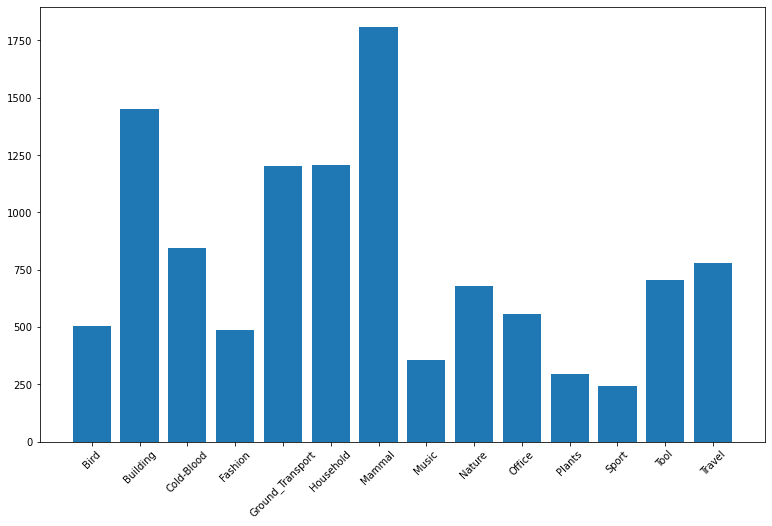

In [19]:
domain_class_frequency = domain_recat.groupby('category').count().label
plt.figure(figsize=(13,8))
plt.xticks(rotation = 45)
plt.bar(domain_class_frequency.index, domain_class_frequency.values)

In [20]:
sample_amount = 300

<BarContainer object of 14 artists>

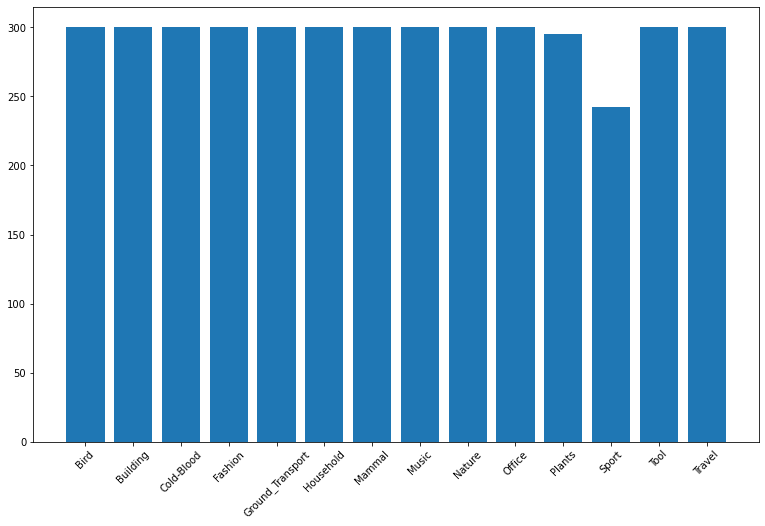

In [21]:
#sub sample each category that exceeds the threshold
domain_recat = sub_sample_domain(domain_recat, sample_amount)

#checking our new class freqeuncy
new_class_frequency = domain_recat.groupby('category').count().label
plt.figure(figsize=(13,8))
plt.xticks(rotation = 45)
plt.bar(new_class_frequency.index, new_class_frequency.values)

In [ ]:
explore_tfds_cats(domain_recat, category = False, sub_category = 'owl')

## Saving Images

In [26]:
#remove currently existing directory, create again
import shutil 

shutil.rmtree(r'C:\Users\fynn\Documents\Lighthouse_Labs\Final\image_dir', ignore_errors=False, onerror=None)
os.makedirs("../image_dir")

#test
im = Image.fromarray(painting_images[0])
im = im.resize((240, 160), Image.ANTIALIAS)
im.save("../image_dir/test_file.jpeg",  dpi=(50, 50)

In [31]:
from random import sample

#sub sampling from painting and food
painting_images = sample(painting_images, sample_amount)
food_images = sample(painting_images, sample_amount)

#save paintings and food into their directories
#paintings
if not os.path.exists("../image_dir/painting_dir"):
    os.makedirs("../image_dir/painting_dir")

for i in range(len(painting_images)):
    im = Image.fromarray(painting_images[i])
    im = im.resize((240, 160), Image.ANTIALIAS)
    im.save(f"../image_dir/painting_dir/{i}.jpeg",  dpi=(50, 50))
    
#food
if not os.path.exists("../image_dir/food_dir"):
    os.makedirs("../image_dir/food_dir")

for i in range(len(food_images)):
    im = Image.fromarray(food_images[i])
    im = im.resize((240, 160), Image.ANTIALIAS)
    im.save(f"../image_dir/food_dir/{i}.jpeg",  dpi=(50, 50))

In [32]:
#save domain images into directories per category
#for every category create a category folder
for category in domain_recat.category:
    
    if not os.path.exists(f"../image_dir/{category}_dir"):
        os.makedirs(f"../image_dir/{category}_dir")

#for every image load and resize image then save into appropriate category directory
for i in domain_recat.index:
    im = Image.fromarray(domain_recat.image[i])
    im = im.resize((240, 160), Image.ANTIALIAS)
    
    for category in domain_recat.category: 
        
        if domain_recat.category[i] == category:
            im.save(f"../image_dir/{category}_dir/{i}.jpeg",  dpi=(50, 50))  

In [ ]:
stop

# Unsplash

## Set up/Test

In [ ]:
import requests as re
import pandas as pd
import numpy as np

# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(0, '../..')

from APIKeys import unsplash_access_key

In [ ]:
#Basic api call function
def API(root, search_term, param, header=None):
    """
    'search_term' must be a string of valid end point queries 
            - as specified by the relevent documentation
            
    OUTPUT: JSON of results
   """
 
    #define endpoint
    if search_term is not None:
        #if search_term is defined add it to the root to make the endpoint
        endpoint = root + search_term
    else:
        #otherwise endpoint is just the root
        endpoint = root
    
    #GET
    response = re.get(endpoint, params = param, headers=header)
   
    #return status code and results
    status_code, results = response.status_code, response.json()
    
    #Let's make sure it worked
    if status_code != 200:
        print('Something went wrong!')
        print(status_code)
        
    return results

In [ ]:
params = {'client_id': unsplash_access_key}
unsplash_root = 'https://api.unsplash.com/'

test = API(unsplash_root, 'photos/random', param = params)

In [ ]:


response = requests.get(test['urls']['raw'])
img = Image.open(BytesIO(response.content)) #fairly slow, should limit how much im doing this
plt.imshow(img)

## Search by topic

In [ ]:
def unsplash_term_queries(term, pages = 1, orientation = 'landscape'):
    
    queries = []
    
    for i in range(0, pages):
        params = {'client_id': unsplash_access_key,
                  'query': term,
                  'page': i + 1,
                  'per_page': 30,
                  'orientation': orientation}
    
        queries.append(API(unsplash_root, 'search/photos', param = params)['results'])
        
    return queries

In [ ]:
def json_to_images(json_results):
    image_arrays = []
    
    for photo_data in json_results:
        response = requests.get(photo_data['urls']['raw'])
        img = Image.open(BytesIO(response.content))
    
        image_arrays.append(np.asarray(img))
        
    return image_arrays

def queries_to_images(queries):
    
    images = []
    
    for query in queries:
        temp = json_to_images(query)
        
        for image in temp:
            images.append(image)
            
    return images

In [ ]:
#-- API Calling (limit: 50/hour) --
bird_queries = unsplash_term_queries('bird', 3)

In [ ]:
bird_supplement = queries_to_images(bird_queries)
        
len(bird_supplement)

# Old Script

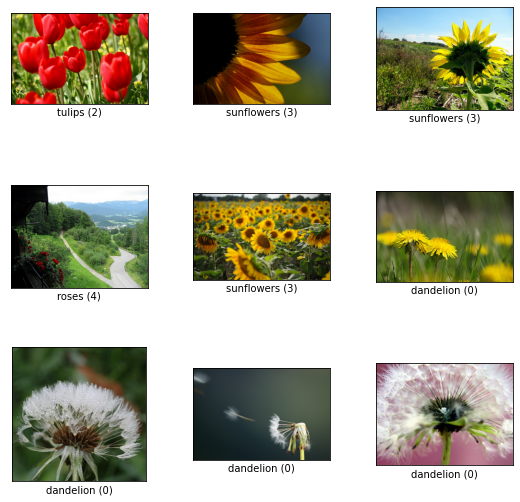

In [3]:
flower_ds, flower_info = tfds.load('tf_flowers', split='train', with_info = True, as_supervised=True)

fig = tfds.show_examples(flower_ds, flower_info)

In [ ]:
from skimage.transform import resize

def resize_images(tfds_key, new_ratio = (340, 500)):

    images_resize = []

    for image in tfds_key.image:
    
        resized = resize(image, new_ratio)
    
        images_resize.append(resized)
    
    
    return images_resize

In [ ]:
#test resizing an image
test_image = tfds_dataset.image[0]
resized_image = resize(test_image, (340, 500))
plt.imshow(resized_image)

In [ ]:
#resizing the images of each key
flower_key['image'] = resize_images(flower_key)
food_key['image'] = resize_images(food_key)
painting_key['image'] = resize_images(painting_key)

# -- DESTROYS COMP DONT USE --
#domain_recat['image'] = resize_images(domain_recat)

### Pulling together

In [ ]:
flower_key = tfds_to_frame(flower_images, flower_labels, sample_amount)
food_key = tfds_to_frame(food_images, food_labels, sample_amount)
painting_key = tfds_to_frame(painting_images, painting_labels, sample_amount)

#create named sub category based on int labels
flower_key['sub_category'] = flower_key.label.replace({0: 'dandelion', 1: 'daisy', 2: 'tulips', 3: 'sunflowers', 4: 'roses'})
#food_key['sub_category'] = food_key.label.replace(list(range(min(food_key.label), max(food_key.label) + 1)),  food_info.features['label'].names)

#add column of category
flower_key['category'] = 'Flower'
#food_key['category'] = 'Food'
painting_key['category'] = 'Painting'

In [ ]:
tfds_dataset = pd.concat([flower_key, food_key, painting_key, domain_recat], ignore_index = True)

print(len(tfds_dataset)) #11K datapoints

#checking our overall category freqeuncy
tfds_frequency = tfds_dataset.groupby('category').count().label
plt.figure(figsize=(13,8))
plt.xticks(rotation = 45)
plt.bar(tfds_frequency.index, tfds_frequency.values)

### Resizing images

In [ ]:
from torch.utils.data import Dataset, TensorDataset
import torch

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
tensor_images = []

for image in tfds_dataset.image:
    tensor_test = tf.convert_to_tensor(image)
    tensor_test = tf.image.resize(tensor_test, (160, 240), antialias = True)
    tensor_images.append(tensor_test)

In [ ]:
convert_tensor = []

for image in tensor_images:
    convert_tensor.append(image.astype(np.uint8))

    
tfds_dataset['image'] = convert_tensor

In [ ]:
explore_tfds_cats(tfds_dataset, category = False, sub_category = 'daisy')

In [ ]:
tfds_dataset.image[100].shape